In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
class DataPreprocessing:

  def drop_dupicates(self, company_dict, company_data, verbose=True):
    # Validation checks
    if verbose:
      total_rows = sum(len(df) for df in company_dict.values())
      expected_total_datarows = 25*4*200  # Quarterly analysis in 25 years for 200 companies
      print(f"Combined {len(company_dict)} company dataframes")
      print(f"Expected total rows: {expected_total_datarows}")
      print(f"Actual combined rows: {total_rows}")

      if total_rows != expected_total_datarows:
          print("WARNING: Row count mismatch! Some data may be duplicated or missing.")


    for company, df in company_dict.items():
      df.drop_duplicates(subset='Date', keep='first',inplace=True)
      # if df['Company'].size != 100:
      #   print("company size : ", df['Company'].size)

    companies_with_unequal_rows = company_data.groupby('Company').size()[company_data.groupby('Company').size()!=100]
    if not companies_with_unequal_rows.empty:
        print("Companies with rows not equal to 100:")
        print(companies_with_unequal_rows)
    else:
        print("Now all companies have 100 rows.")

    return company_dict

  # It is observed if Price is null, PE ratio is null.
  # Therefore, removing the companies with more than 75% Price value null
  # In this case, companies 091 and 121
  def check_for_75_percent_price_null(self, company_dict):
    company_with_null_price = []
    for company, df in company_dict.items():
      # 1. Quantify the missing data for these companies
      companies_with_nulls = df[df['Price'].isna() & df['PE ratio'].isna()]['Company'].unique()
      if companies_with_nulls:
        print(f"Companies with null Price and PE ratio: {companies_with_nulls}")

        # 2. Check what percentage of each company's data is missing
        for company in companies_with_nulls:
          company_data = df[df['Company'] == company]
          missing_percentage = company_data['Price'].isna().mean() * 100
          print(f"{company}: {missing_percentage:.2f}% of Price values missing")
          if missing_percentage > 75.00:
            company_with_null_price.append(companies_with_nulls[0])
            print("company_with_null_price : ",company_with_null_price)

          # Check if missing values are in specific time periods
          missing_periods = company_data[company_data['Price'].isna()]['Date']
          print(f"Missing periods: {missing_periods.min()} to {missing_periods.max()}")

      # 3. Check if other metrics are also missing for these periods
        for company in companies_with_nulls:
          company_missing_data = df[(df['Company'] == company) & df['Price'].isna()]
          missing_counts = company_missing_data.isna().sum()
          print(f"{company} missing value counts in periods with missing Price:")
          print(missing_counts)

    for company in company_with_null_price:
      print("company with more than 75% Price values as null : ",company)
      try:
        print(f"Delete {company} data from dictionary : ")
        del company_dict[company]
      except KeyError as e:
          print(f"Error: {e}")

    return company_dict

  def impute_with_forward_backward_average(self, company_dict, columns_to_impute=None):
    imputed_dict = {}

    for company, df in company_dict.items():
        # Make a copy to avoid modifying the original
        df_copy = df.copy()
        cols = [col for col in columns_to_impute if col in df_copy.columns]

        # For each column with missing values
        for col in cols:
            if df_copy[col].isna().any():
                # Create forward-filled and backward-filled versions
                forward_filled = df_copy[col].fillna(method='ffill')
                backward_filled = df_copy[col].fillna(method='bfill')

                # For values that are still missing after one-directional fill
                # (this happens at the beginning or end of the series)
                forward_filled = forward_filled.fillna(backward_filled)
                backward_filled = backward_filled.fillna(forward_filled)

                # Average the two filled series where original had NaN
                mask = df_copy[col].isna()
                df_copy.loc[mask, col] = (forward_filled[mask] + backward_filled[mask]) / 2

                # Check if any values are still missing (should be rare)
                still_missing = df_copy[col].isna().sum()
                if still_missing > 0:
                    print(f"Warning: {company}, {col} still has {still_missing} missing values")

        imputed_dict[company] = df_copy

    return imputed_dict

  def handle_missing_values(self, company_dict):
    for _, df in company_dict.items():
      # Convert Price column to positive (It is observed that PE ratio value is negative because of EPS and not price, also price should be logically positive.)
      df['Price'] = df['Price'].abs()
      # Missing Price
      df.loc[df['Price'].isna() & df['PE ratio'].notna() & df['EPS'].notna(), 'Price'] = df['PE ratio'] * df['EPS']
      # Missing EPS
      df.loc[df['EPS'].isna() & df['Price'].notna() & df['PE ratio'].notna(), 'EPS'] = abs(df['Price']) / df['PE ratio']
      # Missing PE ratio
      mask = df['PE ratio'].isna() & df['Price'].notna() & df['EPS'].notna() & (df['EPS'] != 0)
      df.loc[mask, 'PE ratio'] = abs(df.loc[mask, 'Price']) / df.loc[mask, 'EPS']

    columns_to_impute = ['Price', 'Revenue', 'Free cash flow', 'Total Debt', 'EPS', 'PE ratio', 'ROE']
    company_dict = self.impute_with_forward_backward_average(company_dict, columns_to_impute=columns_to_impute)

    return company_dict

  def create_target_column(self, combined_df):
    combined_df['Next_Quarter_Price'] = combined_df.groupby('Company')['Price'].shift(-1)
    combined_df['Return'] = (combined_df['Next_Quarter_Price'] - combined_df['Price']) / combined_df['Price']
    combined_df['Target'] = (combined_df['Return'] > 0).astype(int)
    combined_df.dropna(subset=['Next_Quarter_Price'], inplace=True)
    return combined_df


In [11]:
class utils:

  def read_csv(self):
    df = pd.read_csv('dataset.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(['Company', 'Date'], inplace=True)
    return df

  # function to get all the information needed
  def information_func(self, df):
    print("Unique companies in dataset:", df['Company'].nunique())
    print("----"*20)

    # metadata of dataset
    print("Metadata of the dataset:\n")
    df.info()
    print("----"*20)

    # missing values
    null = df.isnull().sum()
    print(null)
    print("----"*20)

  def create_dict_of_dataframes_for_each_company(self, df):
      company_dict = {}
      for company in df['Company'].unique():
        company_dict[company] = df[df['Company']== company]
      return company_dict

  # The data contains duplicates in Date column, since the stocks are recorded quarterly for 25 years,
  # the data per company should be 25*4 = 100, therefore removing duplicates
  def plot_size_histogram_of_company(self, df):
      df.groupby('Company').size().plot.hist()
      plt.xlabel("Rows / Dataframe")
      plt.ylabel("Frequency")
      plt.legend(loc='upper right')
      fig = plt.gcf()

  def combine_dict_dataframes(self, company_dict):
    dfs_to_combine = []
    for company, df in company_dict.items():
      dfs_to_combine.append(df)
    combined_df = pd.concat(dfs_to_combine, ignore_index=True)

    # Sort by Company and Date if Date column exists
    if 'Date' in combined_df.columns:
        combined_df = combined_df.sort_values(['Company', 'Date'])

    return combined_df

  def check_if_any_column_value_null(self, company_dict):
    for _, df in company_dict.items():
      columns_with_nan = df.columns[df.isnull().any()].tolist()
    print("The list of columns having null values : ",columns_with_nan)


Unique companies in dataset: 200
--------------------------------------------------------------------------------
Metadata of the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20200 entries, 0 to 20199
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      20200 non-null  int64         
 1   Date            20200 non-null  datetime64[ns]
 2   Company         20200 non-null  object        
 3   Price           19998 non-null  float64       
 4   Revenue         16713 non-null  float64       
 5   Free cash flow  17934 non-null  float64       
 6   Total Debt      17914 non-null  float64       
 7   ROE             16702 non-null  float64       
 8   EPS             16714 non-null  float64       
 9   PE ratio        17210 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 1.5+ MB
----------------------------------------------

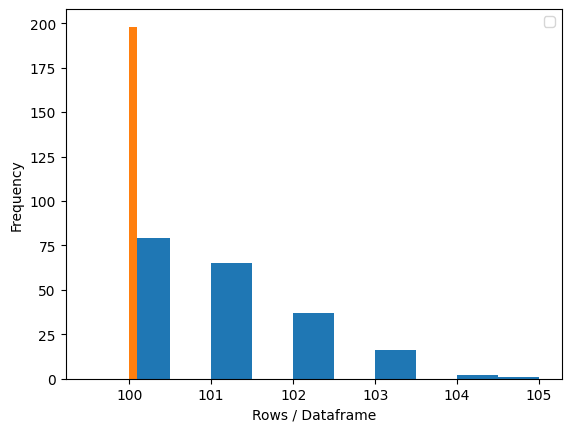

In [5]:
util = utils()
data_preprocessing = DataPreprocessing()
df = util.read_csv()
util.information_func(df)
util.plot_size_histogram_of_company(df)
dict_df = util.create_dict_of_dataframes_for_each_company(df)
dict_df = data_preprocessing.drop_dupicates(dict_df, df)
dict_df = data_preprocessing.check_for_75_percent_price_null(dict_df)
dict_df = data_preprocessing.handle_missing_values(dict_df)
util.check_if_any_column_value_null(dict_df)
combined_df = util.combine_dict_dataframes(dict_df)
util.plot_size_histogram_of_company(combined_df)
combined_df = data_preprocessing.create_target_column(combined_df)
dict_df = util.create_dict_of_dataframes_for_each_company(combined_df)

In [6]:
combined_df.to_csv("dataset_preprocessed.csv", index=False)

To do:
1. Graph for ROE, EPS, PE ratio-comparative analysis
2. standardization or normalization
3. check if cross validation can be performed
4. Models: Matrix profiling, LSTM, ARIMA, TS Bert

In [12]:
util = utils()
combined_df = pd.read_csv("dataset_preprocessed.csv")
dict_df = util.create_dict_of_dataframes_for_each_company(combined_df)

### Model : Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

company_models = {}
accuracy = []

for company,_ in dict_df.items():
    company_data = combined_df[combined_df['Company'] == company]
    # Split into train and test
    train_data = company_data[company_data['Date'] < '2020-01-01']
    test_data = company_data[company_data['Date'] >= '2020-01-01']

    X_train = train_data[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
    y_train = train_data['Target']
    X_test = test_data[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
    y_test = test_data['Target']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = RandomForestClassifier()
    model.fit(X_train_scaled, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    accuracy.append(accuracy_score(y_test, y_pred))
    print(f'Accuracy for {company}: {accuracy_score(y_test, y_pred)}')

    # Save model
    company_models[company] = model
print("Test accuracy : ", sum(accuracy)/len(accuracy))

Accuracy for Company_001: 0.7894736842105263
Accuracy for Company_002: 0.7894736842105263
Accuracy for Company_003: 0.6842105263157895
Accuracy for Company_004: 0.47368421052631576
Accuracy for Company_005: 0.5263157894736842
Accuracy for Company_006: 0.8421052631578947
Accuracy for Company_007: 0.8947368421052632
Accuracy for Company_008: 0.631578947368421
Accuracy for Company_009: 0.5789473684210527
Accuracy for Company_010: 0.631578947368421
Accuracy for Company_011: 0.2631578947368421
Accuracy for Company_012: 0.5263157894736842
Accuracy for Company_013: 0.42105263157894735
Accuracy for Company_014: 0.47368421052631576
Accuracy for Company_015: 0.5789473684210527
Accuracy for Company_016: 0.7368421052631579
Accuracy for Company_017: 0.5263157894736842
Accuracy for Company_018: 0.7368421052631579
Accuracy for Company_019: 0.631578947368421
Accuracy for Company_020: 0.631578947368421
Accuracy for Company_021: 0.3157894736842105
Accuracy for Company_022: 0.3684210526315789
Accuracy fo

In [ ]:
# company = 'Company_089'
# try:
#   model = company_models[company]
#   X_new = ['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']  # Replace with actual values
#   X_new_scaled = scaler.transform(X_new)
#   prediction = model.predict(X_new_scaled)
#   print(f'Prediction for {company}: {prediction}')
# except KeyError as e:
#           print(f"Error: {e}")


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Split into train and test
train_data = combined_df[combined_df['Date'] < '2020-01-01']
test_data = combined_df[combined_df['Date'] >= '2020-01-01']

X_train = train_data[['Company','Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
y_train = train_data['Target']
X_test = test_data[['Company','Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
y_test = test_data['Target']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']])
X_test_scaled = scaler.transform(X_test[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']])

# Train model
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")
train_precision = precision_score(y_train, y_train_pred)
print(f"Training Precision: {train_precision}")
train_recall = recall_score(y_train, y_train_pred)
print(f"Training Recall: {train_recall}")
train_f1 = f1_score(y_train, y_train_pred)
print(f"Training F1 Score: {train_f1}")
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
print(f"Training Confusion Matrix:\n {train_confusion_matrix}")

# Evaluate model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
confusion_matrix_test = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n {confusion_matrix_test}")

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1 Score: 1.0
Accuracy: 0.5635300372142478
Precision: 0.6141323172843782
Recall: 0.7705345501955672
F1 Score: 0.6835003855050116


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Split into train and test
train_data = combined_df[combined_df['Date'] < '2020-01-01']
test_data = combined_df[combined_df['Date'] >= '2020-01-01']

X_train = train_data[['Company','Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
y_train = train_data['Target']
X_test = test_data[['Company','Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
y_test = test_data['Target']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']])
X_test_scaled = scaler.transform(X_test[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']])

# Train model
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")
train_precision = precision_score(y_train, y_train_pred)
print(f"Training Precision: {train_precision}")
train_recall = recall_score(y_train, y_train_pred)
print(f"Training Recall: {train_recall}")
train_f1 = f1_score(y_train, y_train_pred)
print(f"Training F1 Score: {train_f1}")
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
print(f"Training Confusion Matrix:\n {train_confusion_matrix}")

# Evaluate model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
confusion_matrix_test = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n {confusion_matrix_test}")

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1 Score: 1.0
Training Confusion Matrix:
 [[6580    0]
 [   0 9260]]
Accuracy: 0.5635300372142478
Precision: 0.6134251290877797
Recall: 0.7744458930899609
F1 Score: 0.6845946984248944
Confusion Matrix:
 [[ 338 1123]
 [ 519 1782]]


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Split into train and test
train_data = combined_df[combined_df['Date'] < '2020-01-01']
test_data = combined_df[combined_df['Date'] >= '2020-01-01']

X_train = train_data[['Company','Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
y_train = train_data['Target']
X_test = test_data[['Company','Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
y_test = test_data['Target']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']])
X_test_scaled = scaler.transform(X_test[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']])

# Train model
model = RandomForestClassifier(n_estimators = 12, n_jobs=-1)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")
train_precision = precision_score(y_train, y_train_pred)
print(f"Training Precision: {train_precision}")
train_recall = recall_score(y_train, y_train_pred)
print(f"Training Recall: {train_recall}")
train_f1 = f1_score(y_train, y_train_pred)
print(f"Training F1 Score: {train_f1}")
train_classification_report = classification_report(y_train, y_train_pred)
print(f"Training Classification Report:\n {train_classification_report}")
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
print(f"Training Confusion Matrix:\n {train_confusion_matrix}")

# Evaluate model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
classification_report_test = classification_report(y_test, y_pred)
print(f"Classification Report:\n {classification_report_test}")
confusion_matrix_test = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n {confusion_matrix_test}")

# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Training Accuracy: 0.954040404040404
Training Precision: 0.9501899535669058
Training Recall: 0.9723542116630669
Training F1 Score: 0.9611443210930828
Training Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94      6580
           1       0.95      0.97      0.96      9260

    accuracy                           0.95     15840
   macro avg       0.95      0.95      0.95     15840
weighted avg       0.95      0.95      0.95     15840

Training Confusion Matrix:
 [[6108  472]
 [ 256 9004]]
Accuracy: 0.5300372142477405
Precision: 0.6096256684491979
Recall: 0.6440677966101694
F1 Score: 0.6263736263736264
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.35      0.37      1461
           1       0.61      0.64      0.63      2301

    accuracy                           0.53      3762
   macro avg       0.50      0.50      0.50      3762
weighted avg       0.52 

Training Accuracy: 0.9558712121212121
Training Precision: 0.9829628793862123
Training Recall: 0.9408207343412527
Training F1 Score: 0.9614302267836451
Training Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      6580
           1       0.98      0.94      0.96      9260

    accuracy                           0.96     15840
   macro avg       0.95      0.96      0.95     15840
weighted avg       0.96      0.96      0.96     15840

Training Confusion Matrix:
 [[6429  151]
 [ 548 8712]]
Accuracy: 0.5037214247740563
Precision: 0.6148148148148148
Recall: 0.5049978270317254
F1 Score: 0.5545215938916727
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.50      0.44      1461
           1       0.61      0.50      0.55      2301

    accuracy                           0.50      3762
   macro avg       0.50      0.50      0.50      3762
weighted avg       0.53

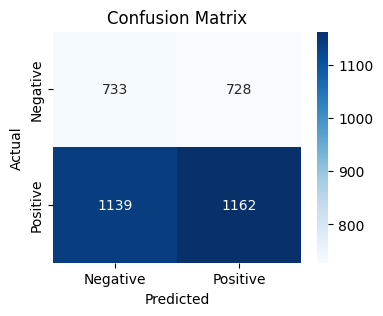

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Split into train and test
train_data = combined_df[combined_df['Date'] < '2020-01-01']
test_data = combined_df[combined_df['Date'] >= '2020-01-01']

X_train = train_data[['Company','Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
y_train = train_data['Target']
X_test = test_data[['Company','Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']]
y_test = test_data['Target']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']])
X_test_scaled = scaler.transform(X_test[['Price','Revenue','Free cash flow','Total Debt','ROE','EPS','PE ratio']])

# Train model
model = RandomForestClassifier(n_estimators = 6)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")
train_precision = precision_score(y_train, y_train_pred)
print(f"Training Precision: {train_precision}")
train_recall = recall_score(y_train, y_train_pred)
print(f"Training Recall: {train_recall}")
train_f1 = f1_score(y_train, y_train_pred)
print(f"Training F1 Score: {train_f1}")
train_classification_report = classification_report(y_train, y_train_pred)
print(f"Training Classification Report:\n {train_classification_report}")
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
print(f"Training Confusion Matrix:\n {train_confusion_matrix}")

# Evaluate model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
classification_report_test = classification_report(y_test, y_pred)
print(f"Classification Report:\n {classification_report_test}")
confusion_matrix_test = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n {confusion_matrix_test}")

# Plot confusion matrix
# Test data : stock rises-2188, stock drops-1378
import seaborn as sns
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Model : Temporal Fusion Transformer(TFT)
Why this model:
1. Pretrained
2. Uses Attention mechanism
3. Supports Multivariate features
4. Can handle irregular time series data
5. Robust to missing data (rows)

In [ ]:
!pip install pytorch_forecasting
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Here an additional column 'Date_idx' is needed for this model TFT

Why?

Company-Specific Time Index:
1. The Date column is repeated for all companies, but the temporal order of the data is specific to each company.
For example, 31-03-2000 is the first quarter for Company_001, but it is also the first quarter for Company_002. The model needs to understand the sequential order of quarters within each company.
2. TFT require a numerical time index (time_idx) to define the temporal order of the data. This index must be company-specific to ensure the model understands the sequence of quarters for each company.
3. If we use the Date column directly, the model might not distinguish between the same date for different companies. A company-specific numerical index ensures the temporal order is preserved for each company and avoids confusion with repeated Dates.


In below step, we will see that the Date_idx gives a certain numerical value to each unique date.

In [ ]:
try:
  company_data_df = pd.read_csv("dataset_preprocessed.csv")

  # Convert date to numerical index for time-series modeling
  company_data_df= company_data_df.sort_values(by=["Company", "Date"])
  # print(company_data_df[['Date','Company']])

  # Create a company-specific time index
  company_data_df['Date_idx'] = company_data_df.groupby('Company').cumcount()
  print("company_data_df['Date_idx'] : ",company_data_df['Date_idx'][98:300])

except FileNotFoundError:
    print("Error: 'dataset_preprocessed.csv' not found. Please run the preprocessing steps first.")
    pass


company_data_df['Date_idx'] :  98     98
99      0
100     1
101     2
102     3
       ..
295    97
296    98
297     0
298     1
299     2
Name: Date_idx, Length: 202, dtype: int64


In [ ]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
# from pytorch_lightning import Trainer
from lightning.pytorch import Trainer
import torch
import torchmetrics # Import the loss from torchmetrics
from sklearn.metrics import accuracy_score # Import accuracy_score for evaluation

In [ ]:
import pytorch_forecasting
import lightning.pytorch
print(f"PyTorch Forecasting version: {pytorch_forecasting.__version__}")
print(f"PyTorch Lightning version: {lightning.pytorch.__version__}")

PyTorch Forecasting version: 1.3.0
PyTorch Lightning version: 2.5.1.post0


In [ ]:
# keeping aside 20% data for test ~18 values
data_train_val = company_data_df[company_data_df['Date'] < '2020-04-01']
test_data = company_data_df[company_data_df['Date'] >= '2020-04-01']

In [ ]:
def walk_forward_splits(data, n_splits=4, min_val_size = 1):
    """
    Generate walk-forward splits for time-series data.
    :param data: DataFrame containing the time-series data.
    :param n_splits: Number of validation splits.
    :param min_val_size: Minimum size of the validation set.
    :return: List of (train_data, val_data) tuples.
    """
    splits = []
    data = data.sort_values(by=["Company", "Date_idx"])
    unique_dates = sorted(data['Date_idx'].unique())
    split_size = len(unique_dates) // (n_splits+1)

    for i in range(n_splits):
        train_end_idx = split_size * (i + 1)
        val_start_idx = train_end_idx
        val_end_idx = val_start_idx + split_size

        # Ensure validation set has a minimum size
        if val_end_idx > len(unique_dates) or len(unique_dates[val_start_idx:val_end_idx]) < min_val_size:
            break

        train_dates = unique_dates[:train_end_idx]
        val_dates = unique_dates[val_start_idx:val_end_idx]

        train_data = data[data['Date_idx'].isin(train_dates)]
        val_data = data[data['Date_idx'].isin(val_dates)]

        splits.append((train_data, val_data))

    return splits

In [ ]:
from torchmetrics import Metric
class BCEWithLogitsLossMetric(Metric):
    def __init__(self):
        super().__init__()
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
      pass

    def compute(self):
      pass

    def forward(self, y_pred, y_true):
        return self.loss_fn(y_pred.squeeze(), y_true.float())


    # def __init__(self):
    #     super().__init__()
    #     self.loss_fn = torch.nn.BCEWithLogitsLoss()
    #     # You might also want to add state to accumulate loss,
    #     # but for this simple example, just returning the loss is okay if used directly.
    #     # For proper Metric usage, you would typically update state in update()
    #     # and compute the final metric in compute().

    # def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
    #     # In a real Metric, you would accumulate loss here.
    #     # For a loss function wrapper, you might not need this if just using it in the model definition.
    #     pass # Or implement accumulation if needed for averaging over batches/epochs

    # def compute(self):
    #     # In a real Metric, you would compute the final result here.
    #     # For a loss function wrapper, this method might not be strictly necessary
    #     # if the forward pass is used directly as the loss.
    #     pass # Or implement final computation if needed

    # def forward(self, y_pred, y_true):
    #     # This method is used by PyTorch Lightning/TFT when this is set as the loss
    #     # It calculates the loss for a given batch.
    #     # Ensure y_true has the correct type and shape if necessary for BCEWithLogitsLoss
    #     return self.loss_fn(y_pred.squeeze(), y_true.float()) # Squeeze y_pred and cast y_true to float

In [ ]:
def create_tft_datasets(train_data, val_data):
  """
  Create TFT-compatible datasets for training and validation.
  :param train_data: Training data for the current fold.
  :param val_data: Validation data for the current fold.
  :return: train_dataset, val_dataset
  """
  train_dataset = TimeSeriesDataSet(
      train_data,
      time_idx="Date_idx",
      target="Target",
      group_ids=["Company"],
      max_encoder_length=12,  # Use past 12 quarters
      max_prediction_length=1,  # Predict next quarter
      static_categoricals=["Company"],
      time_varying_known_reals=["Price", "Revenue", "Free cash flow", "Total Debt", "ROE", "EPS", "PE ratio"],
      time_varying_unknown_reals=["Target"],
  )

  # val_dataset = TimeSeriesDataSet(
  #     val_data,
  #     time_idx="Date_idx",
  #     target="Target",
  #     group_ids=["Company"],
  #     max_encoder_length=12,
  #     max_prediction_length=1,
  #     static_categoricals=["Company"],
  #     time_varying_known_reals=["Price", "Revenue", "Free cash flow", "Total Debt", "ROE", "EPS", "PE ratio"],
  #     time_varying_unknown_reals=["Target"],
  # )

  val_dataset = TimeSeriesDataSet.from_dataset(
       train_dataset, # Use train_dataset to copy scalers and other parameters
       val_data,      # Provide the validation data
       # Adjust parameters if needed, but keep consistent with train_dataset
       # Ensure prediction length is consistent
       stop_randomization=True, # Important for validation/test sets
       predict_mode=True,
       add_relative_time_idx = True
  )


  return train_dataset, val_dataset

In [ ]:
splits = walk_forward_splits(data_train_val, n_splits=4)

val_results = []

for fold_idx, (train_data, val_data) in enumerate(splits):
  print(f"\nTraining fold {fold_idx + 1}...")

  train_dataset, val_dataset = create_tft_datasets(train_data, val_data)

  # Create dataloaders
  train_dataloader = train_dataset.to_dataloader(train=True, batch_size=8)
  val_dataloader = val_dataset.to_dataloader(train=False, batch_size=8)

  # print(val_dataset)

  custom_loss_metric = BCEWithLogitsLossMetric()

  # Define model
  tft = TemporalFusionTransformer.from_dataset(
      train_dataset,
      learning_rate=0.01,
      hidden_size=16,
      attention_head_size=4,
      dropout=0.1,
      hidden_continuous_size=16,
      output_size=1,  # Binary classification
      loss=custom_loss_metric,
  )

  # Train model
  trainer = Trainer(max_epochs=10)
  trainer.fit(tft, train_dataloader, val_dataloader)

  # # Evaluate model on validation set
  # val_predictions = trainer.predict(tft, val_dataloader)
  # val_targets = torch.cat([y for _, y in iter(val_dataloader)])

  # # Calculate accuracy
  # val_predictions = torch.sigmoid(val_predictions).round()  # Convert logits to binary predictions
  # accuracy = accuracy_score(val_targets.numpy(), val_predictions.numpy())
  # print(f"Fold {fold_idx + 1} Validation Accuracy: {accuracy}")

  # # Store results
  # val_results.append(accuracy)


Training fold 1...


INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | Mult

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



Training fold 2...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwor

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 3...


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 48     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.6 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 4...


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 48     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.6 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
print(f"Validation dataloader size: {len(val_dataloader)}")

Validation dataloader size: 4


In [ ]:
for fold_idx, (train_data, val_data) in enumerate(splits):
  print(f"\nTraining fold {fold_idx + 1}...")

  # Evaluate model on validation set
  val_dataloader = val_dataset.to_dataloader(train=False, batch_size=8)
  # val_predictions = trainer.predict(tft, val_dataloader)
  val_predictions = trainer.validate(model=tft, dataloaders=val_dataloader)
  # val_targets = torch.cat([y for _, y in iter(val_dataloader)])

  # # Calculate accuracy
  # val_predictions = torch.sigmoid(val_predictions).round()  # Convert logits to binary predictions
  # accuracy = accuracy_score(val_targets.numpy(), val_predictions.numpy())
  # print(f"Fold {fold_idx + 1} Validation Accuracy: {accuracy}")

  # # Store results
  # val_results.append(accuracy)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 1...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    1.8807618618011475     │
│         val_MAPE          │        68465376.0         │
│         val_RMSE          │     1.955857515335083     │
│         val_SMAPE         │            2.0            │
│         val_loss          │     0.902840256690979     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 2...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    1.8807618618011475     │
│         val_MAPE          │        68465376.0         │
│         val_RMSE          │     1.955857515335083     │
│         val_SMAPE         │            2.0            │
│         val_loss          │     0.902840256690979     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 3...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    1.8807618618011475     │
│         val_MAPE          │        68465376.0         │
│         val_RMSE          │     1.955857515335083     │
│         val_SMAPE         │            2.0            │
│         val_loss          │     0.902840256690979     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 4...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    1.8807618618011475     │
│         val_MAPE          │        68465376.0         │
│         val_RMSE          │     1.955857515335083     │
│         val_SMAPE         │            2.0            │
│         val_loss          │     0.902840256690979     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
# for batch in val_dataloader:
#     print(batch)

,Unnamed: 0,Date,Company,Price,Revenue,Free cash flow,Total Debt,ROE,EPS,PE ratio,Next_Quarter_Price,Return,Target,Date_idx
81,81,2020-06-30,Company_001,302.4434,320.3149,114.95760,167.4585,6.6181,6.065512,49.862800,303.4718,0.003400,1,81
82,82,2020-09-30,Company_001,303.4718,363.5685,97.97290,213.9510,19.0824,7.969400,38.237700,304.7299,0.004146,1,82
83,83,2020-12-31,Company_001,304.7299,552.4823,98.27210,214.3347,-14.3315,7.914900,39.194000,310.2173,0.018007,1,83
84,84,2021-03-31,Company_001,310.2173,398.8931,112.15230,161.3600,-0.2012,8.570600,36.195517,310.9195,0.002264,1,84
85,85,2021-06-30,Company_001,310.9195,437.4671,113.20840,161.4878,-1.1337,6.258100,49.485200,309.6824,-0.003979,0,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19597,20194,2023-09-30,Company_200,229.1166,366.0900,89.51300,457.0272,-21.3585,3.385600,67.673854,227.8422,-0.005562,0,94
19598,20195,2023-12-31,Company_200,227.8422,269.4530,93.18065,483.3904,-32.5526,5.068037,44.956700,226.9281,-0.004012,0,95
19599,20196,2024-03-31,Company_200,226.9281,172.8160,96.84830,351.0265,-20.2237,0.911500,248.961163,231.7055,0.021052,1,96
19600,20197,2024-06-30,Company_200,231.7055,167.0919,94.71940,472.8211,-7.8948,4.104200,57.297300,235.1578,0.014900,1,97


In [ ]:
from lightning.pytorch.callbacks import Callback

# class SavePredictionsCallback(Callback):
#     def __init__(self, filepath="predictions.txt"):
#         self.filepath = filepath
#         self.predictions = []

#     def on_predict_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
#         self.predictions.extend(outputs)

#     def on_predict_end(self, trainer, pl_module):
#         with open(self.filepath, "w") as f:
#             for pred in self.predictions:
#                 f.write(str(pred) + "\n")


class SavePredictionsCallback(Callback):
    def __init__(self, filepath="predictions.txt"):
        super().__init__() # Ensure parent constructor is called
        self.filepath = filepath
        self.predictions = []

    def on_predict_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        # Ensure outputs is a list or tensor before extending
        if isinstance(outputs, torch.Tensor):
             self.predictions.extend(outputs.tolist())
        elif isinstance(outputs, list):
             # Handle cases where outputs might be nested or complex
             # Simple flattening if outputs is a list of tensors/items
             self.predictions.extend([item.tolist() if isinstance(item, torch.Tensor) else item for item in outputs])
        else:
             # Handle other potential output types if necessary
             self.predictions.append(outputs)


    def on_predict_end(self, trainer, pl_module):
        # Process collected predictions before saving if needed (e.g., flatten)
        processed_predictions = []
        for pred in self.predictions:
            if isinstance(pred, list):
                processed_predictions.extend(pred) # Flatten list of lists
            else:
                processed_predictions.append(pred)


        with open(self.filepath, "w") as f:
            for pred in processed_predictions:
                f.write(str(pred) + "\n")


In [ ]:
# import pytorch_forecasting.callbacks
# from pytorch_forecasting.callbacks import PredictCallback
# from lightning.pytorch.callbacks import Callback

for fold_idx, (train_data, val_data) in enumerate(splits):
  print(f"\nTraining fold {fold_idx + 1}...")

  custom_callback = SavePredictionsCallback(filepath=f"predictions_fold_{fold_idx+1}.txt")
  trainer = Trainer(callbacks=[custom_callback], max_epochs=1)

  train_dataset, val_dataset = create_tft_datasets(train_data, val_data)

  # Evaluate model on validation set
  val_dataloader = val_dataset.to_dataloader(train=False, batch_size=8)
  val_predictions = trainer.predict(tft, val_dataloader)
  # val_predictions = trainer.validate(model=tft, dataloaders=val_dataloader)
  val_targets = torch.cat([y for _, y in iter(val_dataloader)])

  # Calculate accuracy
  val_predictions = torch.sigmoid(val_predictions).round()  # Convert logits to binary predictions
  accuracy = accuracy_score(val_targets.numpy(), val_predictions.numpy())
  print(f"Fold {fold_idx + 1} Validation Accuracy: {accuracy}")

  # Store results
  val_results.append(accuracy)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training fold 1...


Predicting: |          | 0/? [00:00<?, ?it/s]

IndexError: list index out of range

In [ ]:
# print(f"Output size: {tft.hparams.output_size}")
# print(f"Loss function: {tft.hparams}")

Evaluation

In [ ]:
# Create TFT dataset for the test set
test_dataset = TimeSeriesDataSet(
    test_data,
    time_idx="Date_idx",
    target="Target",
    group_ids=["Company"],
    max_encoder_length=12,  # Use past 12 quarters
    max_prediction_length=1,  # Predict next quarter
    static_categoricals=["Company"],
    time_varying_known_reals=["Price", "Revenue", "Free cash flow", "Total Debt", "ROE", "EPS", "PE ratio"],
    time_varying_unknown_reals=["Target"],
)

# Create test dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=16)

# Evaluate model on test set
test_predictions = trainer.test(model=tft, dataloaders=test_dataloader)
# test_predictions = trainer.predict(tft, test_dataloader)
# test_targets = torch.cat([y for _, y in iter(test_dataloader)])

# # Calculate test accuracy
# test_predictions = torch.sigmoid(test_predictions).round()  # Convert logits to binary predictions
# test_accuracy = accuracy_score(test_targets.numpy(), test_predictions.numpy())
# print(f"Test Accuracy: {test_accuracy}")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MAE          │    0.9414722919464111     │
│         test_MAPE         │        40287088.0         │
│         test_RMSE         │     1.150607943534851     │
│        test_SMAPE         │    1.6564548015594482     │
│         test_loss         │    0.6567850112915039     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
# Collect predictions and true labels
all_preds = []
all_targets = []

for batch in test_dataloader:
    x, y = batch
    preds = tft(x).prediction  # Forward pass through the model
    preds = torch.sigmoid(preds).round().view(-1)  # Apply sigmoid and round for binary classification
    # all_preds.append(preds.detach().cpu().numpy())
    # all_targets.append(y[0].detach().cpu().numpy())
    all_preds.append(preds)
    all_targets.append(y[0].view(-1))


# Flatten the lists
# all_preds = torch.cat(all_preds).numpy()
# all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).detach().cpu().numpy()
all_targets = torch.cat(all_targets).detach().cpu().numpy()


In [ ]:
print(all_preds)
print(all_targets)
# Print the shapes to verify they are now 1D
print(f"Shape of all_targets: {all_targets.shape}")
print(f"Shape of all_preds: {all_preds.shape}")

[0. 0. 1. ... 1. 1. 1.]
[1 1 0 ... 1 1 1]
Shape of all_targets: (1188,)
Shape of all_preds: (1188,)


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_targets, all_preds)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[326 215]
 [261 386]]


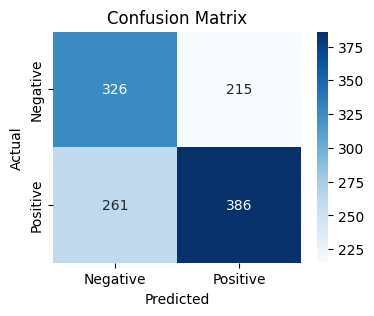

In [ ]:
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()